In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=8

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

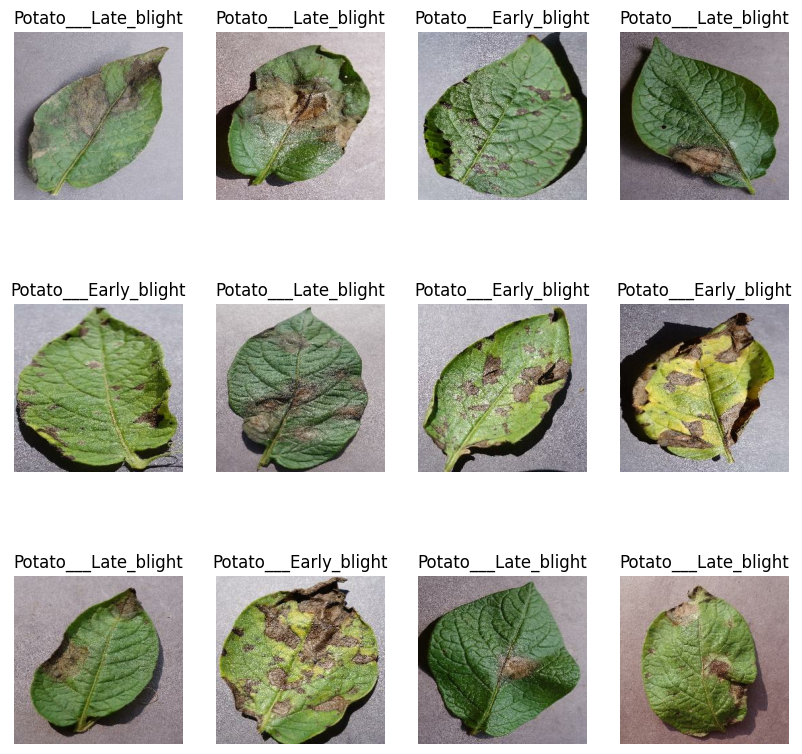

In [5]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[0].shape)
    #print(image_batch[0].numpy())
    #print(label_batch.numpy())
    #print(label_batch[0].numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [6]:
#function to split dataset
# we will divide dataset into 3 parts.
# 1.Training: Dataset to be used while training
# 2.Validation: Dataset to be tested against while training
# 3.Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#resize the image into (256,256) because when we are done with the training and start using the model for predictions. 
#At that time someone can supply an image that is not (256,256) and this layer will resize it.
#To improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/8
54/54 [==============================] - 110s 2s/step - loss: 0.9044 - accuracy: 0.4977 - val_loss: 0.8418 - val_accuracy: 0.7708
Epoch 2/8
54/54 [==============================] - 104s 2s/step - loss: 0.7270 - accuracy: 0.6499 - val_loss: 0.4624 - val_accuracy: 0.8229
Epoch 3/8
54/54 [==============================] - 111s 2s/step - loss: 0.5104 - accuracy: 0.7980 - val_loss: 0.3509 - val_accuracy: 0.8958
Epoch 4/8
54/54 [==============================] - 102s 2s/step - loss: 0.3696 - accuracy: 0.8484 - val_loss: 0.4314 - val_accuracy: 0.8594
Epoch 5/8
54/54 [==============================] - 103s 2s/step - loss: 0.2418 - accuracy: 0.9149 - val_loss: 0.1225 - val_accuracy: 0.9479
Epoch 6/8
54/54 [==============================] - 117s 2s/step - loss: 0.1275 - accuracy: 0.9572 - val_loss: 0.0816 - val_accuracy: 0.9740
Epoch 7/8
54/54 [==============================] - 100s 2s/step - loss: 0.1457 - accuracy: 0.9491 - val_loss: 0.0623 - val_accuracy: 0.9740
Epoch 8/8
54/54 [===

In [26]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 554ms/step - loss: 0.1054 - accuracy: 0.9609


In [27]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9044449329376221,
 0.7270477414131165,
 0.510391116142273,
 0.3696107268333435,
 0.2417823076248169]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

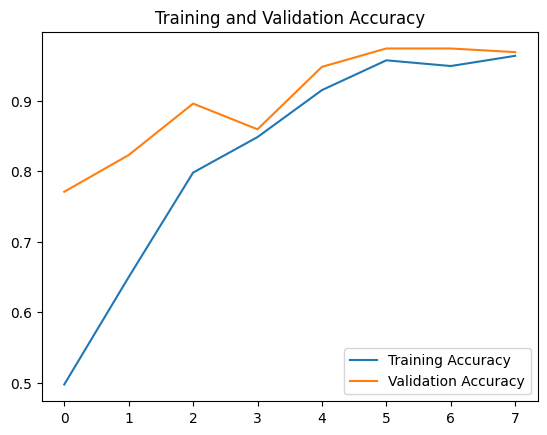

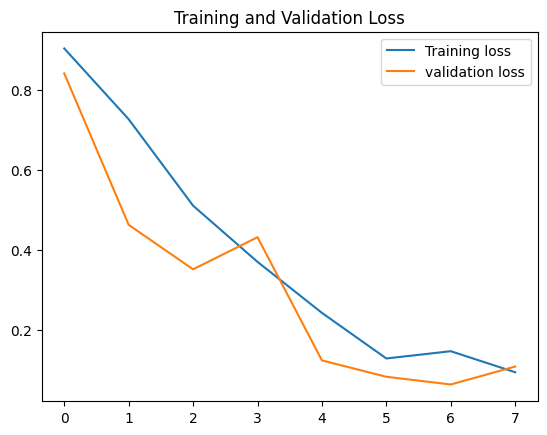

In [31]:
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

actual label: Potato___Late_blight
1/1 [==============================] - 1s 969ms/step
predicted label: Potato___Late_blight


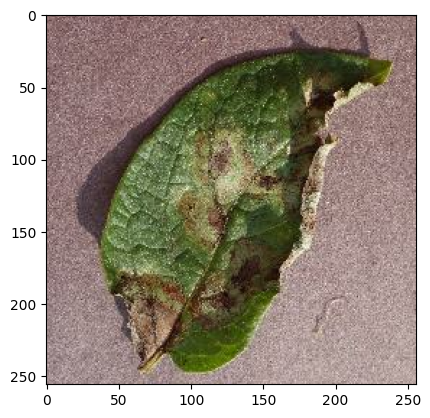

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 1s 609ms/step


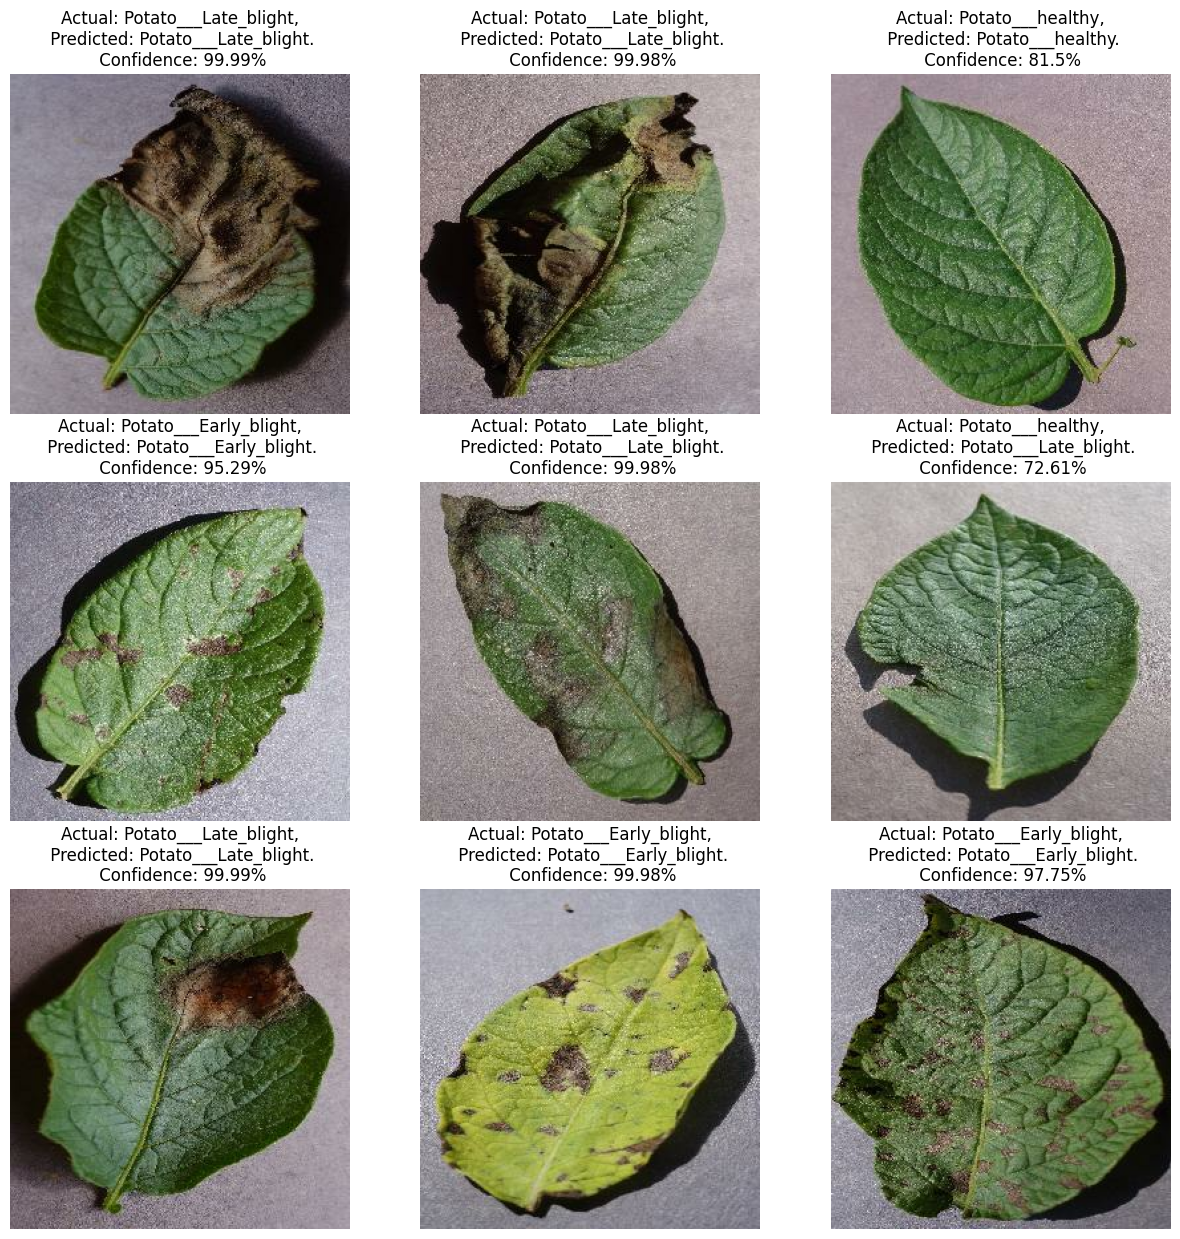

In [33]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        actual_class=class_names[label]
        batch_prediction = model.predict(images_batch)
        predicted_class=class_names[np.argmax(batch_prediction[i])]
        confidence = round(100 * (np.max(batch_prediction[i])), 2)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [35]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [38]:
import os
model_version= max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
